# Notebook for functional clustering

## Importing

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skfda.ml.clustering import KMeans
from sklearn.preprocessing import minmax_scale

from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis, VectorValuedBasis

import salishsea_tools.viz_tools as sa_vi

from tqdm import tqdm

## Files Reading

In [ ]:
ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(time_counter = (np.arange(0, len(ds.time_counter),2)), 
    y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(time_counter = (np.arange(0, len(ds2.time_counter),2)), 
    y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))


## Functions

In [ ]:
def drivers_preprocessing(dataset,dataset2):

    input = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x))),
        ])

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(input[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880))) # input[1] because this variable is down to 100m
    input =input[:,:,indx[0]]

    # Transforming each variable individually
    for j in range (0, len(input)):

        temp = minmax_scale(np.ravel(input[j]))
        input[j] = temp.reshape(input[j].shape)

    # Converting it to an appropriate format for functional clustering
    input = np.transpose(input,axes=(2,1,0)) # this is the right shape for converting it to a functional variable
    input2 = FDataGrid(input, np.arange(0,len(dataset.time_counter)))

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    # Sorting so that cluster 1 has the minimum mean target value, 6 the maximum

    # Finding the mean of each cluster
    a = []
    for j in range (0,6):
        a.append(np.mean(input[np.where(kmeans.labels_==j),:,0])) # We do the sorting based on Temperature_(0m-15m)

    # The index to sort the clusters
    indx3 = np.argsort(np.argsort(a)) # For the complete map we need the double np.argsort

    # First fwe define all as the first cluster
    clusters = xr.where(kmeans.labels_==0, indx3[0], kmeans.labels_)
    # Then we overwrite the second to last
    for j in np.arange(1,6):

        clusters = xr.where(kmeans.labels_==j, indx3[j], clusters)

    unique, counts = np.unique(clusters, return_counts=True)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"))

    # Creating the individual clusters
    basis_x = FourierBasis(domain_range=(0, len(dataset.time_counter)),n_basis=50)

    basis = VectorValuedBasis(np.repeat(basis_x,7))

    x = kmeans.cluster_centers_.to_basis(basis)
    y = np.array(x.to_grid(np.arange(0,len(dataset.time_counter))).data_matrix)

    indx3 = np.argsort(a) # For the individual maps we need a single np.argsort

    return (clusters2,unique,counts,indx3,y)
    

In [ ]:
def target_preprocessing(dataset,name):
    
    input = np.reshape(np.ravel(dataset[name]), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(input).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
    input = input[:, indx[0]]

    input = input.transpose()

    # Converting it to an appropriate format for functional clustering
    input2 = FDataGrid(input, np.arange(0,len(dataset.time_counter)))

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(input2)
    clusters = kmeans.predict(input2)

    # Sorting so that cluster 1 has the minimum mean target value, 6 the maximum

    # Finding the mean of each cluster
    a = []
    for j in range (0,6):
        a.append(np.mean(input[np.where(kmeans.labels_==j)]))

    # The index to sort the clusters
    indx3 = np.argsort(np.argsort(a)) # For the complete map we need the double np.argsort

    # First we define all as the first cluster
    clusters = xr.where(kmeans.labels_==0, indx3[0], kmeans.labels_)
    # Then we overwrite the second to last
    for j in np.arange(1,6):

        clusters = xr.where(kmeans.labels_==j, indx3[j], clusters)

    unique, counts = np.unique(clusters, return_counts=True)
    
    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

    # Preparation of the dataarray 
    clusters2 = xr.DataArray(clusters,
        coords = {'y': dataset.y, 'x': dataset.x},
        dims = ['y','x'],
        attrs=dict(description="Clusters of the performed functional analysis algorithm",
        long_name ="Cluster",
        units="count"))

    # Creating the individual clusters
    y = np.array(kmeans.cluster_centers_.to_grid().data_matrix)

    indx3 = np.argsort(a) # For the individual maps we need a single np.argsort

    return (clusters2,unique,counts,indx3,y,a)


In [ ]:
def func_clust_drivers_all(dataset,dataset2):
 
    clusters2,unique,counts,indx3,y = drivers_preprocessing(dataset,dataset2)

    # Printing
    for j in range (1,7):
        print('The amount of points for cluster ' + str(j) + ' is: ' + str(counts[j-1]))
    
    fig, ax = plt.subplots(figsize =(5,9))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters2.plot(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')
    ax.set_title('Functional Clustering during 2007-2024 for Drivers')

    sa_vi.set_aspect(ax)

    plt.show()

    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    axs[0, 0].plot(y[indx3[0]])
    axs[0, 0].set_title('Cluster 1')

    axs[0, 1].plot(y[indx3[1]])
    axs[0, 1].set_title('Cluster 2')

    axs[1, 0].plot(y[indx3[2]])
    axs[1, 0].set_title('Cluster 3')

    axs[1, 1].plot(y[indx3[3]])
    axs[1, 1].set_title('Cluster 4')

    axs[2, 0].plot(y[indx3[4]])
    axs[2, 0].set_title('Cluster 5')

    axs[2, 1].plot(y[indx3[5]])
    axs[2, 1].set_title('Cluster 6')

    fig.legend(('Temperature_(0m-15m)','Temperature_(15m-100m)','Salinity_(0m-15m)',
        'Salinity_(15m-100m)','Summation_of_solar_radiation',
        'Mean_wind_speed','Mean_air_temperature'),loc=9)

    plt.show()


In [ ]:
def func_clust_drivers():

    all = []
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    cluster5 = []
    cluster6 = []
    counts_all = []

    for i in tqdm(np.arange(2007,2025)):
    
        dataset = ds.sel(time_counter = slice(str(i), str(i)))
        dataset2 = ds2.sel(time_counter = slice(str(i), str(i)))

        clusters2,unique,counts,indx3,y = drivers_preprocessing(dataset,dataset2)

        all.append(clusters2)

        counts_all.append(counts)

        cluster1.append(y[indx3[0]])
        cluster2.append(y[indx3[1]])
        cluster3.append(y[indx3[2]])
        cluster4.append(y[indx3[3]])
        cluster5.append(y[indx3[4]])
        cluster6.append(y[indx3[5]])

    return (all,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,counts_all,unique)

In [ ]:
def func_clust_target_all(dataset,names):

    for name in names:

        clusters2,unique,counts,indx3,y,a = target_preprocessing(dataset,name)

        # Printing
        for j in range (1,7):
            print('The amount of points for cluster '+str(j)+' is: '+str(counts[j-1])+' with a mean of: '+str(np.round(np.mean(a[np.argsort(a)[j-1]]),3)))
        
        # Plotting
        fig, ax = plt.subplots(figsize =(5,9))

        cmap = plt.get_cmap('tab20', unique.max()+1)
        cmap.set_bad('gray')
        clus = clusters2.plot(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

        cbar = fig.colorbar(clus, ticks = unique+0.5) 
        cbar.set_ticklabels(unique+1)
        cbar.set_label('Clusters [count]')
        ax.set_title('Functional Clustering during 2007-2024 for '+ name)

        sa_vi.set_aspect(ax)

        plt.show()

        fig, axs = plt.subplots(3, 2, figsize=(10, 15))

        axs[0, 0].plot(y[indx3[0]])
        axs[0, 0].set_title('Cluster 1')

        axs[0, 1].plot(y[indx3[1]])
        axs[0, 1].set_title('Cluster 2')

        axs[1, 0].plot(y[indx3[2]])
        axs[1, 0].set_title('Cluster 3')

        axs[1, 1].plot(y[indx3[3]])
        axs[1, 1].set_title('Cluster 4')

        axs[2, 0].plot(y[indx3[4]])
        axs[2, 0].set_title('Cluster 5')

        axs[2, 1].plot(y[indx3[5]])
        axs[2, 1].set_title('Cluster 6')

        plt.show()


In [ ]:
def func_clust_target(name):

    all = []
    cluster1 = []
    cluster2 = []
    cluster3 = []
    cluster4 = []
    cluster5 = []
    cluster6 = []
    counts_all = []

    for i in tqdm(np.arange(2007,2025)):

        dataset = ds.sel(time_counter = slice(str(i), str(i)))
        
        input = np.reshape(np.ravel(dataset[name]), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))

        x =  np.tile(dataset.x, len(dataset.y))
        y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

        indx = np.where((~np.isnan(input).any(axis=0)) & (x>10) & ((x>100) | (y<880)))
        input = input[:, indx[0]]

        input = input.transpose()

        # Converting it to an appropriate format for functional clustering
        input2 = FDataGrid(input, np.arange(0,len(dataset.time_counter)))

        # Training
        n_clusters = 6
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(input2)
        clusters = kmeans.predict(input2)

        # Sorting so that cluster 1 has the minimum mean target value, 6 the maximum

        # Finding the mean of each cluster
        a = []
        for j in range (0,6):
            a.append(np.mean(input[np.where(kmeans.labels_==j)]))

        # The index to sort the clusters
        indx3 = np.argsort(np.argsort(a)) # For the complete map we need the double np.argsort

        # First we define all as the first cluster
        clusters = xr.where(kmeans.labels_==0, indx3[0], kmeans.labels_)
        # Then we overwrite the second to last
        for j in np.arange(1,6):

            clusters = xr.where(kmeans.labels_==j, indx3[j], clusters)

        unique, counts = np.unique(clusters, return_counts=True)
        
        # Creating the map
        indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
        indx2[indx[0]] = clusters
        clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 

        # Preparation of the dataarray 
        clusters2 = xr.DataArray(clusters,
            coords = {'y': dataset.y, 'x': dataset.x},
            dims = ['y','x'],
            attrs=dict(description="Clusters of the performed functional analysis algorithm",
            long_name ="Cluster",
            units="count"))

        all.append(clusters2)
        counts_all.append(counts)
        
        # Creating the individual clusters
        y = np.array(kmeans.cluster_centers_.to_grid().data_matrix)
        
        indx3 = np.argsort(a) # For the individual maps we need a single np.argsort

        cluster1.append(y[indx3[0]])
        cluster2.append(y[indx3[1]])
        cluster3.append(y[indx3[2]])
        cluster4.append(y[indx3[3]])
        cluster5.append(y[indx3[4]])
        cluster6.append(y[indx3[5]])

    return (all,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,counts_all,unique)


## Plotting

In [ ]:
def plotting_drivers(clusters,clusters_ind,unique,counts_all):
    
    years = np.arange(2007,2025)

    fig, ax = plt.subplots(5, 4, figsize=(10, 15))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')

    k=0
    l=0

    for j in np.arange (0,len(years)):

        clus = clusters[j].plot(ax=ax[k,l], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

        cbar = fig.colorbar(clus, ticks=unique+0.5, fraction=0.08, pad=0.08) 
        cbar.set_ticklabels(unique+1)
        # cbar.set_label('Clusters [count]')
        ax[k,l].set_title(str(years[j]))

        sa_vi.set_aspect(ax[k,l])

        l=l+1

        if l==4:
            l=0
            k=k+1

        # Printing
        for i in unique:
            print('The amount of points for cluster '+ str(i+1)+' for year '+str(years[j])+' is: '+str(counts_all[j][i]))
        print('\n')

    ax[4,2].axis('off')
    ax[4,3].axis('off')

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle('Functional Clustering for Drivers')
    plt.show()

    for i in unique:

        k=0
        l=0

        fig, ax = plt.subplots(5, 4, figsize=(10, 15))

        for j in np.arange (0,len(years)):
    
            ax[k, l].plot(clusters_ind[i][j])
            ax[k, l].set_title(str(years[j]))

            l=l+1

            if l==4:
                l=0
                k=k+1

        ax[4,2].axis('off')
        ax[4,3].axis('off')

        fig.legend(('Temperature_(0m-15m)','Temperature_(15m-100m)','Salinity_(0m-15m)',
        'Salinity_(15m-100m)','Summation_of_solar_radiation',
        'Mean_wind_speed','Mean_air_temperature'),loc=4)

        fig.tight_layout(rect=[0, 0, 1, 0.97])
        fig.suptitle('Cluster '+ str(i+1))
        plt.show()
        

In [ ]:
def plotting_targets(name,clusters,clusters_ind,unique,counts_all):
    
    years = np.arange(2007,2025)

    fig, ax = plt.subplots(5, 4, figsize=(10, 15))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')

    k=0
    l=0

    for j in np.arange (0,len(years)):

        clus = clusters[j].plot(ax=ax[k,l], cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

        cbar = fig.colorbar(clus, ticks=unique+0.5, fraction=0.08, pad=0.08) 
        cbar.set_ticklabels(unique+1)
        # cbar.set_label('Clusters [count]')
        ax[k,l].set_title(str(years[j]))

        sa_vi.set_aspect(ax[k,l])

        l=l+1

        if l==4:
            l=0
            k=k+1

        # Printing
        for i in unique:
            print('The amount of points for cluster '+ str(i+1)+' for year '+str(years[j])+' is: '+str(counts_all[j][i])+
                ' with a mean of: '+str(np.round(np.mean(clusters_ind[i][j]),3)))
        print('\n')

    ax[4,2].axis('off')
    ax[4,3].axis('off')

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle('Functional Clustering for ' + str(name))
    plt.show()

    for i in unique:

        k=0
        l=0

        fig, ax = plt.subplots(5, 4, figsize=(10, 15))

        for j in np.arange (0,len(years)):
    
            ax[k, l].plot(clusters_ind[i][j])
            ax[k, l].set_title(str(years[j]))

            l=l+1

            if l==4:
                l=0
                k=k+1

        ax[4,2].axis('off')
        ax[4,3].axis('off')

        fig.tight_layout(rect=[0, 0, 1, 0.97])
        fig.suptitle('Cluster '+ str(i+1))
        plt.show()
        

## Main Body

In [ ]:
# 2007 - 2024

dataset = ds.sel(time_counter = slice('2007', '2024'))
dataset2 = ds2.sel(time_counter = slice('2007', '2024'))

func_clust_drivers_all(dataset,dataset2)

names = ['Diatom', 'Flagellate']

func_clust_target_all(dataset,names)

In [ ]:
# For every year individually (Drivers)

clusters,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,counts_all,unique = func_clust_drivers()
    
clusters = xr.concat(clusters, dim='year')
clusters_ind = []
clusters_ind = ([cluster1,cluster2,cluster3,cluster4,cluster5,cluster6])
plotting_drivers(clusters,clusters_ind,unique,counts_all)


100%|██████████| 18/18 [00:48<00:00,  2.70s/it]


The amount of points for cluster 1 for year 2007 is: 3 with a mean of: 0.483
The amount of points for cluster 2 for year 2007 is: 274 with a mean of: 25.259
The amount of points for cluster 3 for year 2007 is: 490 with a mean of: 26.931
The amount of points for cluster 4 for year 2007 is: 852 with a mean of: 28.205
The amount of points for cluster 5 for year 2007 is: 644 with a mean of: 29.448
The amount of points for cluster 6 for year 2007 is: 694 with a mean of: 30.511


The amount of points for cluster 1 for year 2008 is: 3 with a mean of: 1.727
The amount of points for cluster 2 for year 2008 is: 326 with a mean of: 27.376
The amount of points for cluster 3 for year 2008 is: 708 with a mean of: 28.385
The amount of points for cluster 4 for year 2008 is: 775 with a mean of: 29.072
The amount of points for cluster 5 for year 2008 is: 511 with a mean of: 29.971
The amount of points for cluster 6 for year 2008 is: 634 with a mean of: 30.932


The amount of points for cluster 1 for yea

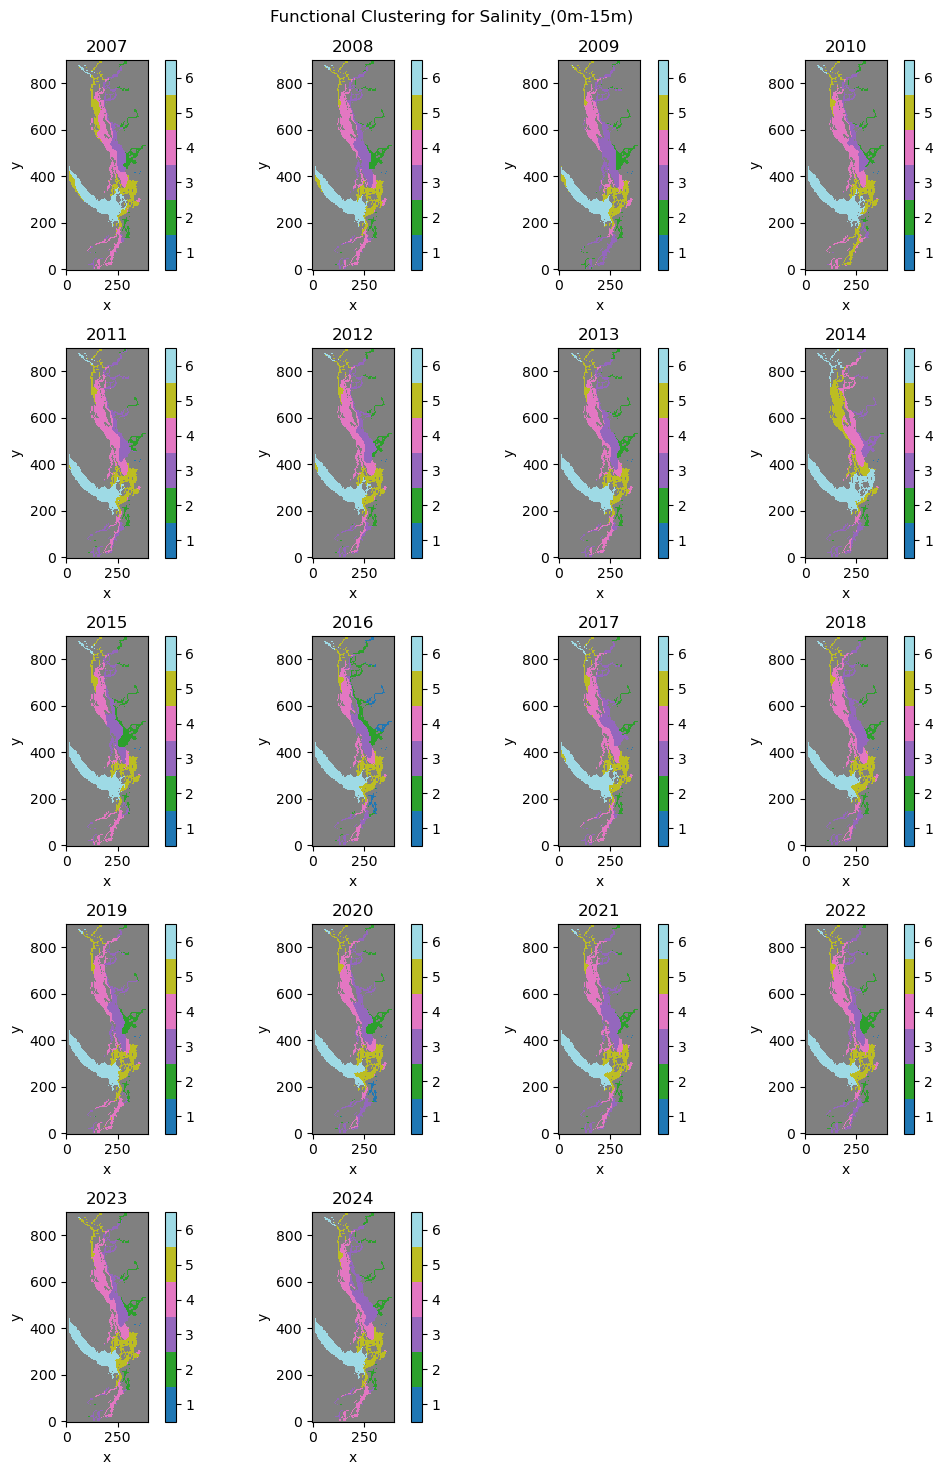

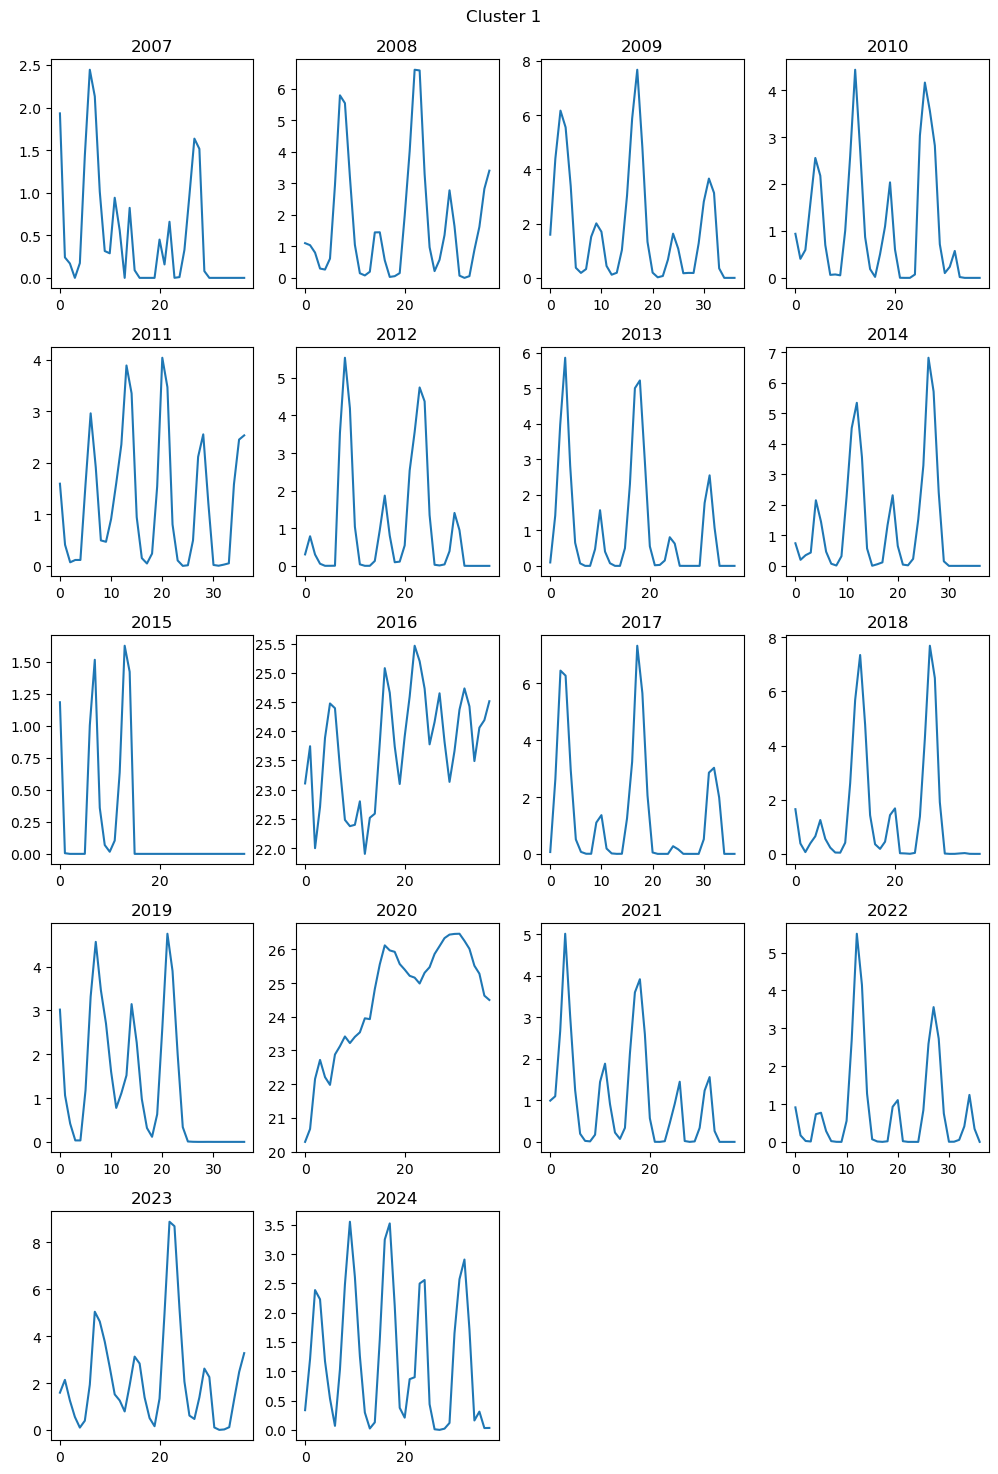

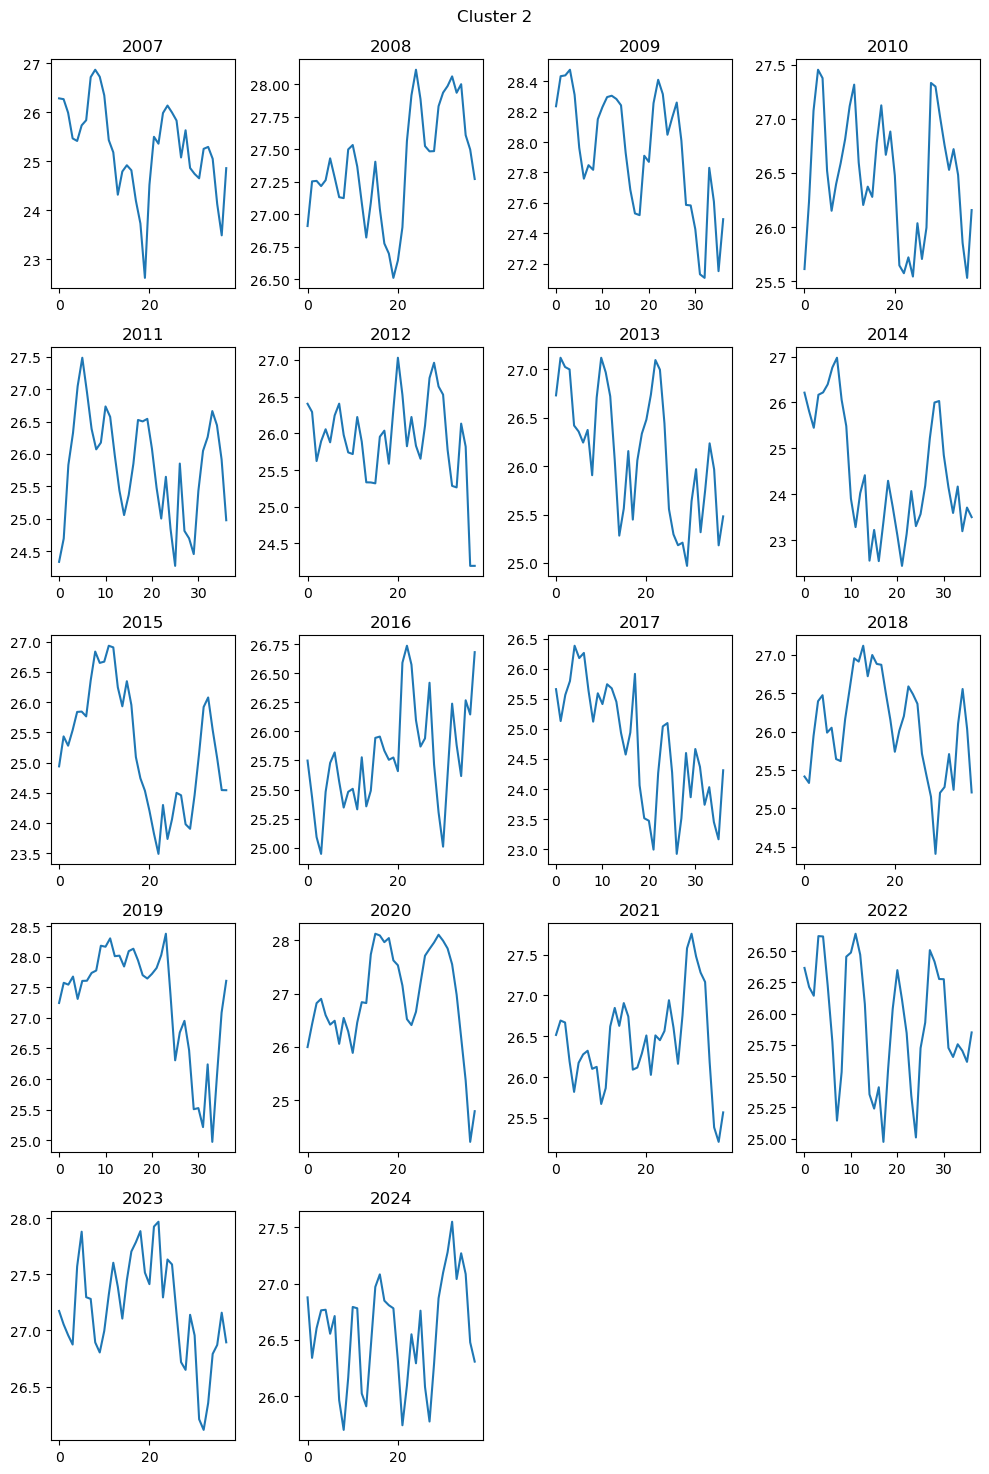

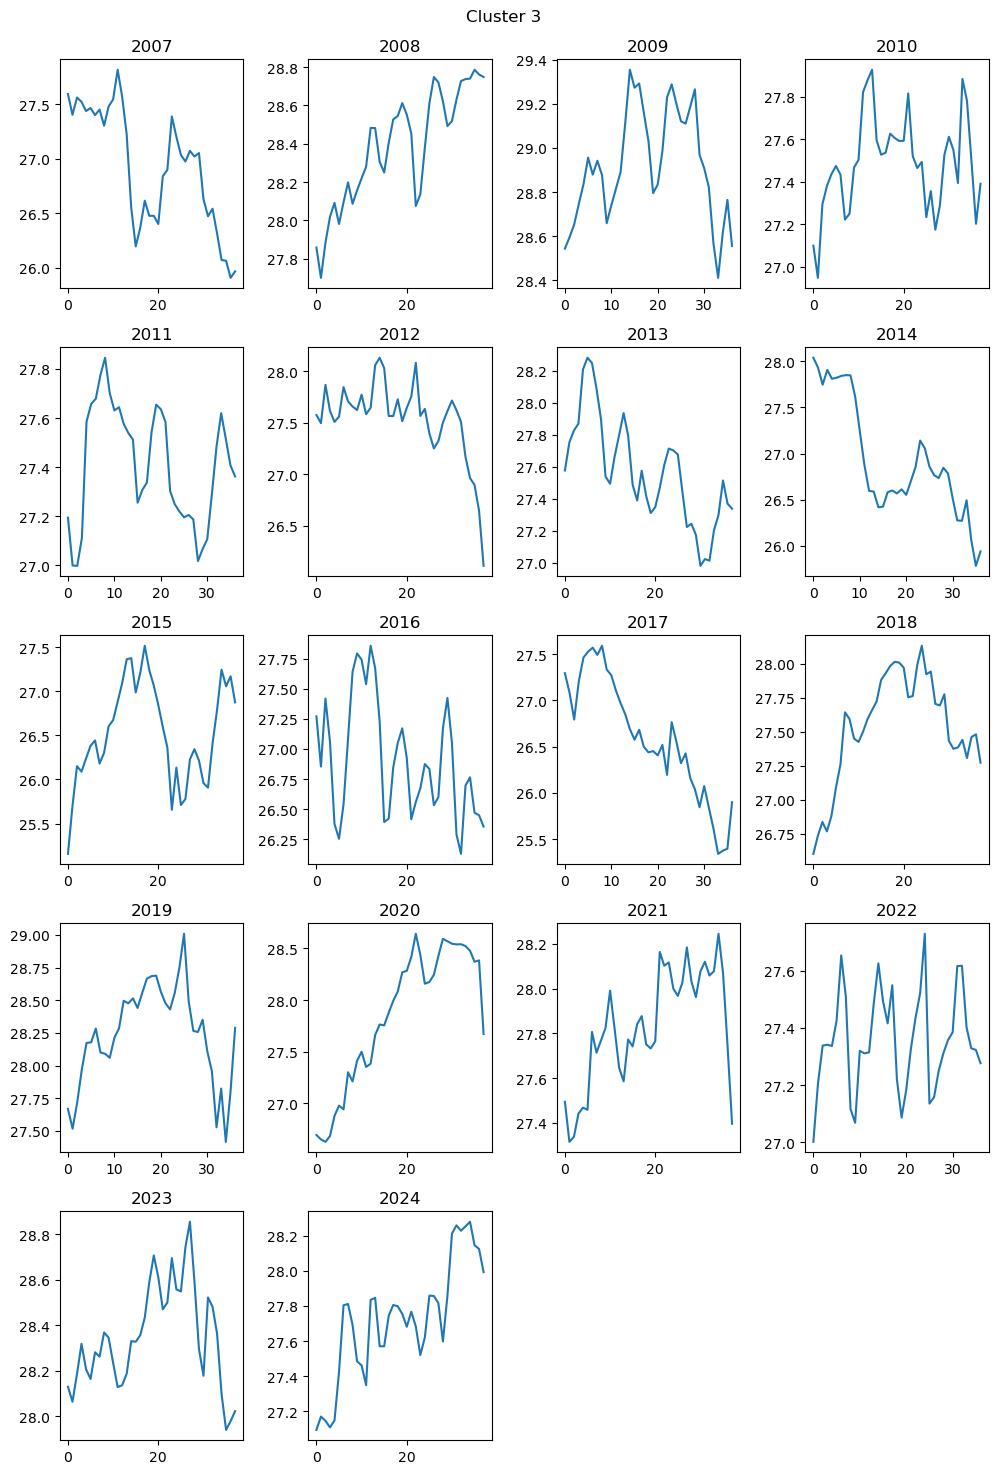

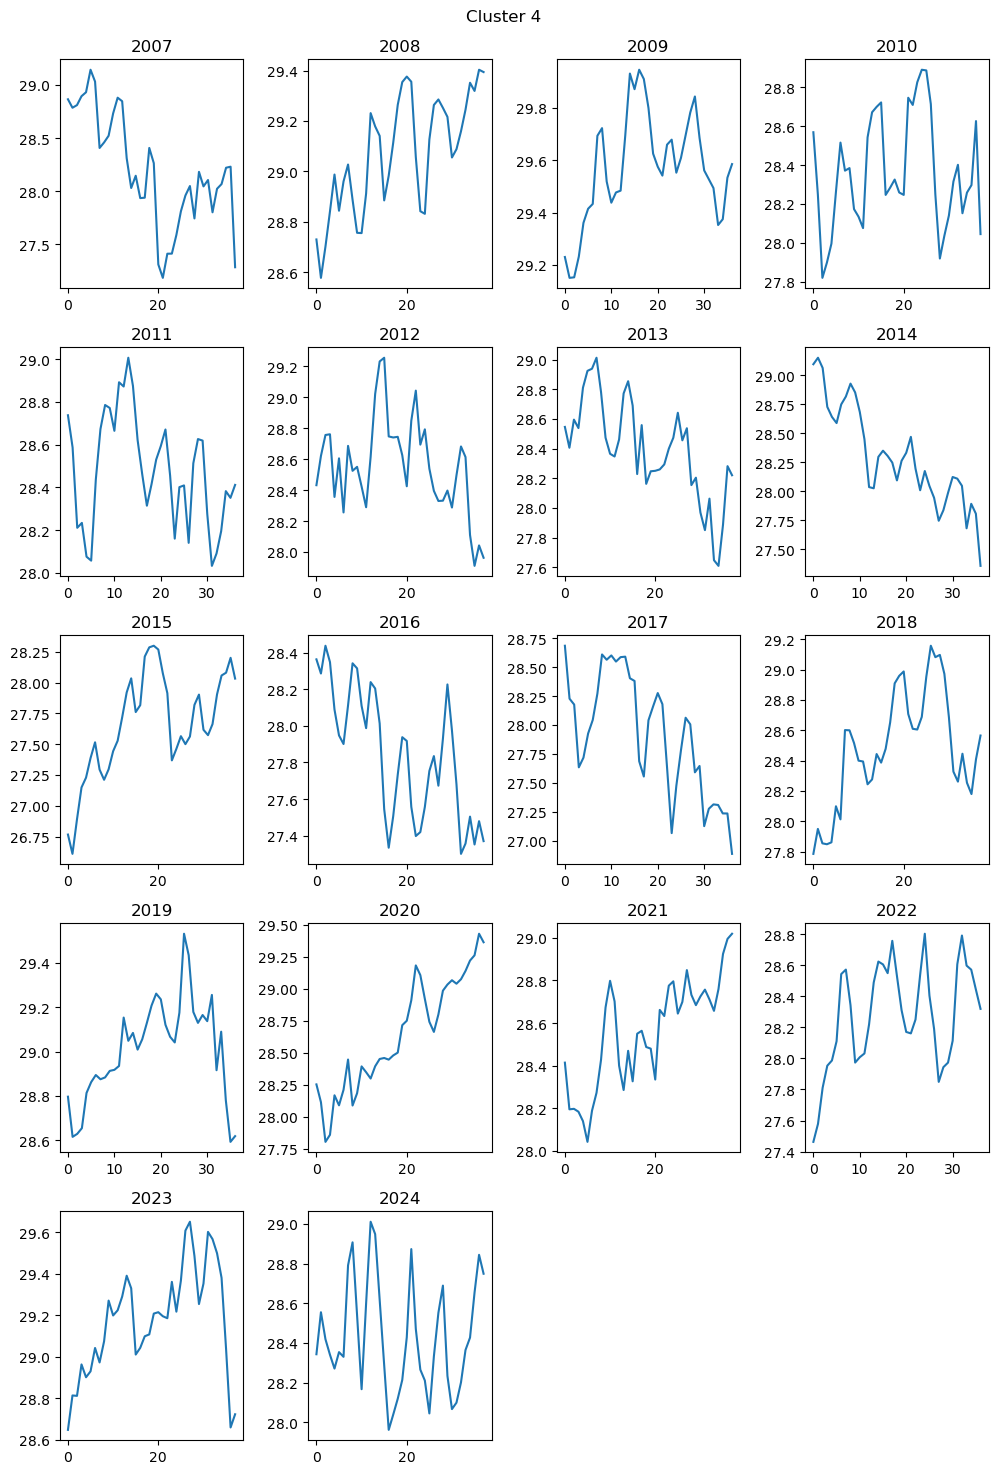

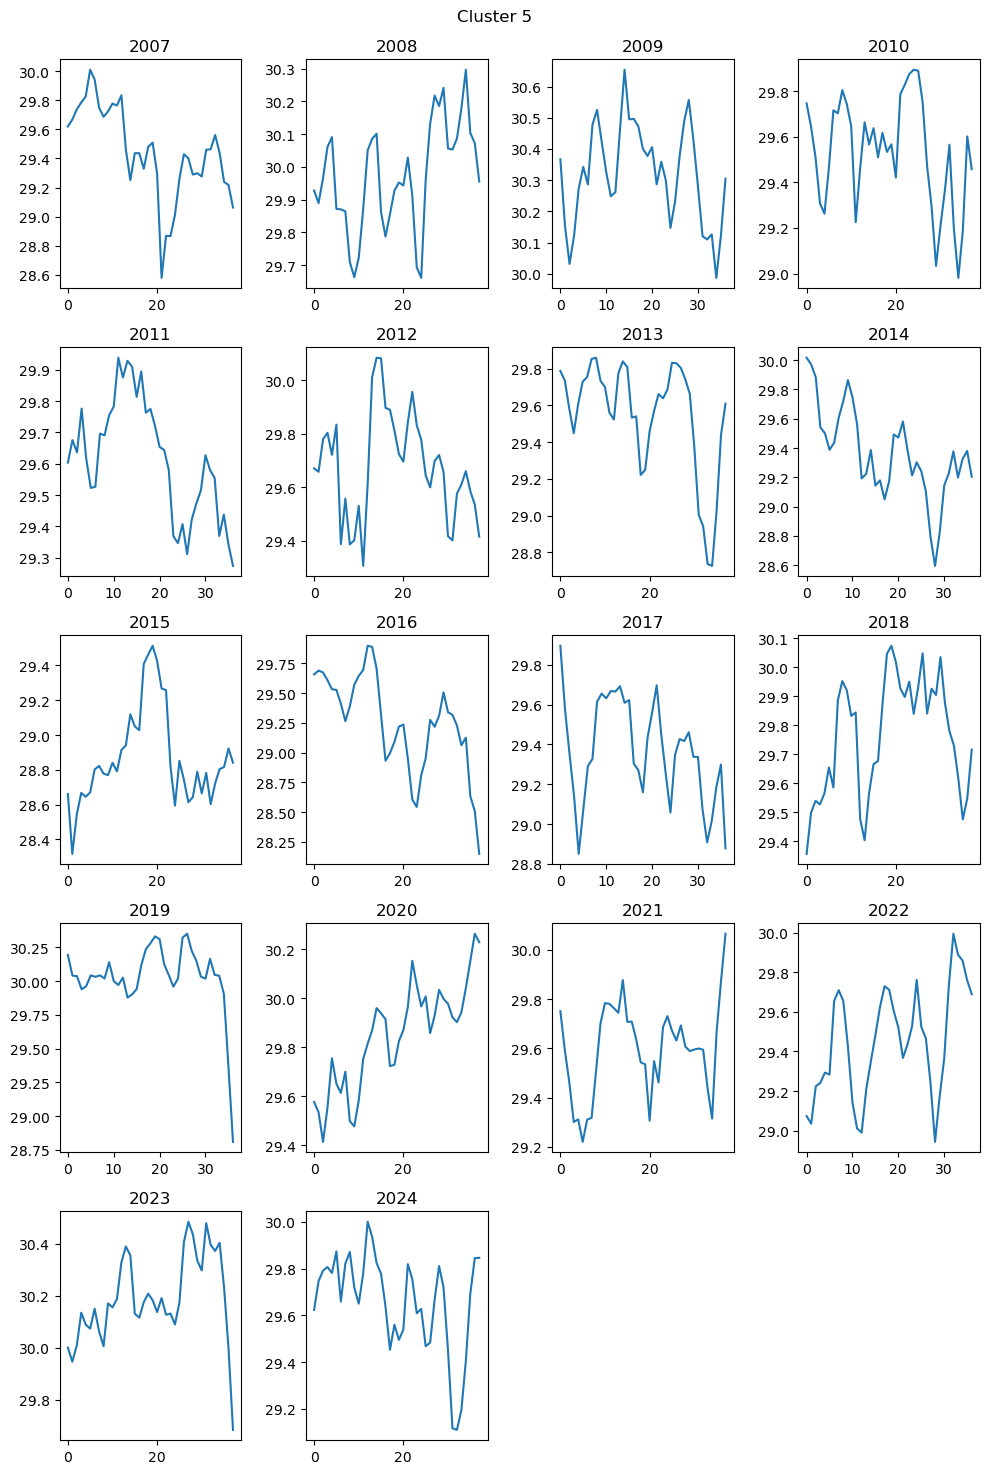

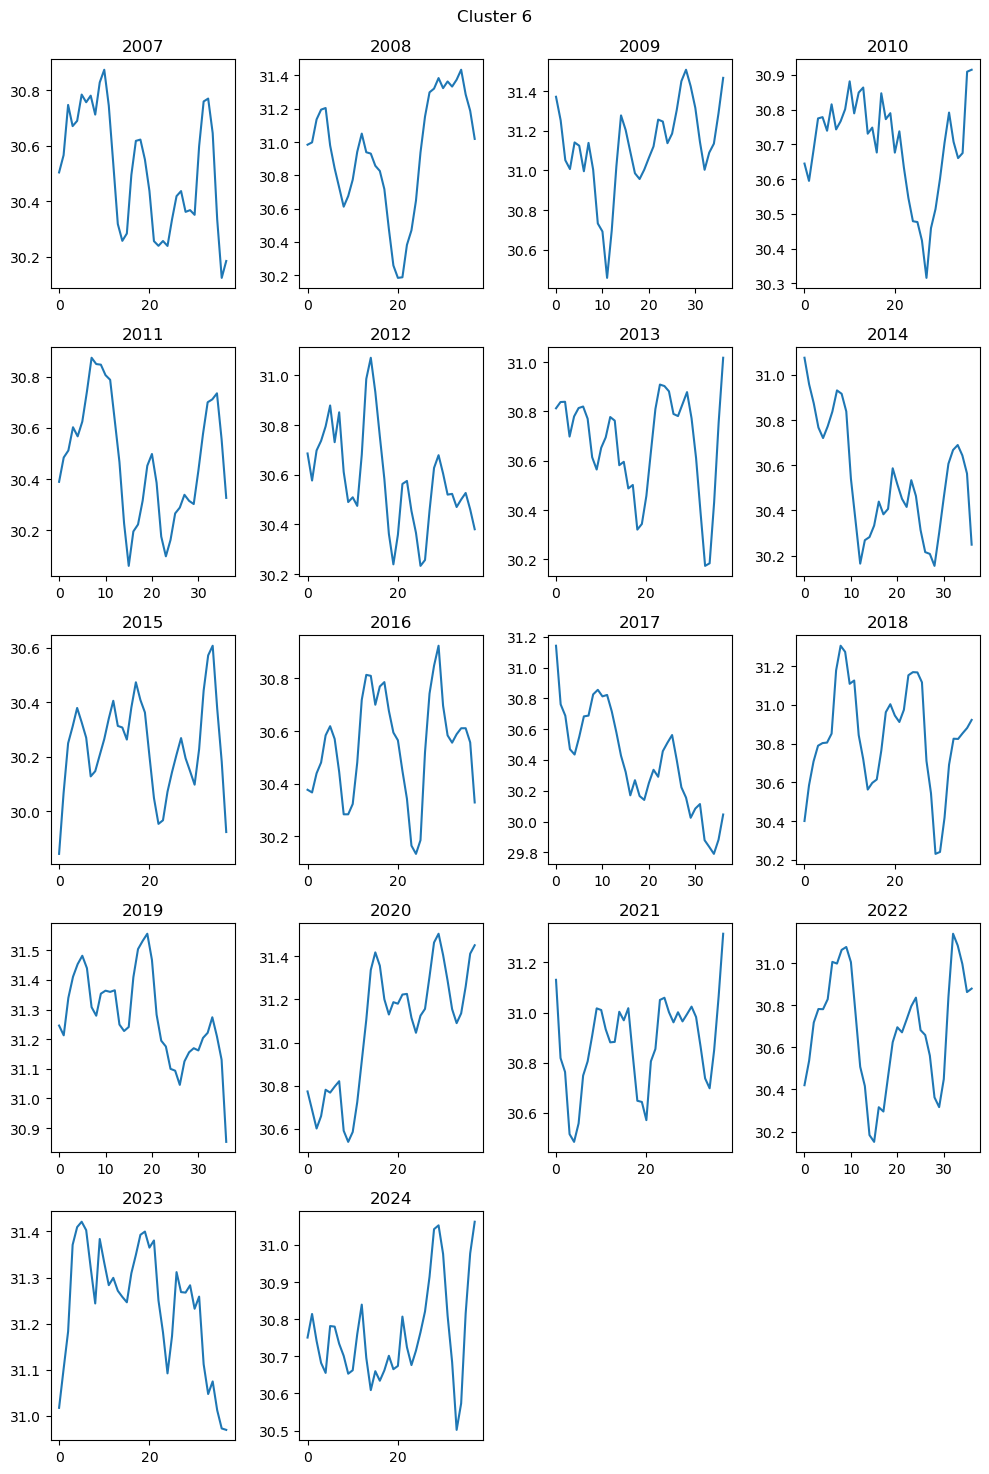

In [66]:
# For every year individually (Targets)

names = ['Salinity_(0m-15m)']

for name in (names):

    clusters,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,counts_all,unique = func_clust_target(name)
    clusters = xr.concat(clusters, dim='year')
    clusters_ind = []
    clusters_ind = ([cluster1,cluster2,cluster3,cluster4,cluster5,cluster6])
    plotting_targets(name,clusters,clusters_ind,unique,counts_all)
    